In [38]:
import sys
# import numpy as np
import os
import openmc
# import h5py
# from scipy import integrate
# from scipy.integrate import cumtrapz
# from beta_pdf import getBetaPDF
# from tqdm import tqdm
import matplotlib.pyplot as plt
# from readLeaprOutput import readLeaprOutput, thinOutTn, getRealisticTn, readTn, getRho
# from gaussian_fits_and_bounding_funcs import conduct_search, get_x_y_for_rejection_envelopes,\
#                                              get_bounding_func_for_rejection,\
#                                              get_approx_fit_for_rejection
# from sampling import sample_simple_rejection, sample_gaussian_approx, sample_TnCDF_method
# from cn import getCn
# njoy_exec = '/Users/ameliajo/NJOY_CLEAN/bin/njoy'

# nphon   = 100
# from misc import get_setup,kb,getAlphaMinMax,get_TnCDFs
# from sampling import get_max_vals_TnCDF_sampling
from egrid import egrid

sys.path.append('./phonon_dists/')
sys.path.append('./helper_funcs/')

from phonon_dists import *


In [2]:
endf_openmc_directory = '/Users/ameliajo/endfb80_hdf5/'
openmc_exec = '/Users/ameliajo/openmc_psm2/openmc/build/bin/openmc'

In [42]:
case = 'c_U_in_UO2'
case = 'c_U_in_UN'
# case = 'c_H_in_YH2'
# case = 'c_H_in_ZrH'
case = 'c_Graphite'
# case = 'c_Zr_in_ZrH'


params = {
    'c_Graphite'               : [0.25,100, crystalline_graphite_x, crystalline_graphite_y, 550],
    'c_U_in_UO2'               : [0.25,100, u_uo2_rho_x, u_uo2_rho_y, 100],
    'c_U_in_UN'                : [0.25, 15, u_in_un_x, u_in_un_y, 100],
    'c_H_in_YH2'               : [0.05, 40, h_yh2_rho_x, h_yh2_rho_y, 250],
#     'c_H_in_ZrH'               : [0.00, 40, h_zrh_rho_x, h_zrh_rho_y],
    'c_H_in_ZrH'               : [0.05, 40, h_zrh_rho_x, h_zrh_rho_y, 100],
    'c_Zr_in_ZrH'              : [0.25, 35, zr_zrh_rho_x, zr_zrh_rho_y, 100],
}
cutoff_energy, aboveThisUseGaussian, rho_x, rho_y, nphon = params[case]

# T,kbT,A,rho_E_L,rhoVals_L,lambda_s,sab_leapr,alphas,fullBetas,TnVec2,TnVec3 = get_setup(case,njoy_exec)

## Bring in the data from the existing HDF5 file

In [43]:
from write_hdf5 import write_hdf5_info

In [44]:
# If you want all temperatures, choose `None`, else specify desired temps in a float
desired_temperatures = None 
# desired_temperatures = [296]

Tdict, max_energy = write_hdf5_info(case,rho_x,rho_y,aboveThisUseGaussian,cutoff_energy,
                                        endf_openmc_directory,nphon=nphon, 
                                        desired_temperatures=desired_temperatures)

1000K


100%|█████████████████████████████████████████| 109/109 [18:23<00:00, 10.12s/it]


1200K


100%|█████████████████████████████████████████| 109/109 [20:47<00:00, 11.44s/it]


1600K


100%|█████████████████████████████████████████| 109/109 [26:18<00:00, 14.48s/it]


2000K


100%|█████████████████████████████████████████| 109/109 [32:17<00:00, 17.78s/it]


296K


100%|█████████████████████████████████████████| 109/109 [10:28<00:00,  5.76s/it]


400K


100%|█████████████████████████████████████████| 109/109 [11:32<00:00,  6.36s/it]


500K


100%|█████████████████████████████████████████| 109/109 [12:38<00:00,  6.96s/it]


600K


100%|█████████████████████████████████████████| 109/109 [13:43<00:00,  7.55s/it]


700K


100%|█████████████████████████████████████████| 109/109 [14:49<00:00,  8.16s/it]


800K


100%|█████████████████████████████████████████| 109/109 [15:59<00:00,  8.80s/it]


In [45]:
!du -sh *.h5

780K	c_Graphite.h5
342M	c_Graphite_old.h5
380K	c_H_in_ZrH.h5
168K	psm.h5
168K	sta.h5
 24K	summary.h5


In [46]:
!{'rm '+case+'_old.h5'}

# Single-scatter collision tests 
### to make sure that differential distributions are consistent

In [47]:
# SINGLE SCATTER COLLISION STUFF

def write_settings(Ein,using_psm,n_particles):
    settings = openmc.Settings()
    settings.run_mode  = 'fixed source'
    settings.batches   = 10
    settings.inactive  = 1
    settings.particles = n_particles
    spatial = openmc.stats.Point([0.0,0.0,0.0])
    angle   = openmc.stats.Isotropic()
    energy  = openmc.stats.Discrete([Ein],[1.0])
    settings.source = openmc.Source(spatial,angle,energy)
    settings.temperature = {'method': 'interpolation'}
    settings.export_to_xml()
    with open("settings.xml", "r") as  in_file: buf = in_file.readlines()
    with open("settings.xml", "w") as out_file:
        for line in buf:
            if "</source>" in line:
                line += "<kill_after_first_round>true</kill_after_first_round>\n"
                if using_psm:
                    line += "<use_psm>true</use_psm>\n"
                else:
                    line += "<use_psm>false</use_psm>\n"
                line += "<inelastic_only>true</inelastic_only>\n"
            out_file.write(line)
            
def write_materials(element,tsl_name,T):
    mat = openmc.Material(name='material',temperature=T)
    mat.set_density('g/cm3', 2.0)
    mat.add_element(element   , 1.0)
    mat.add_s_alpha_beta(tsl_name)
    materials = openmc.Materials([mat])
    materials.cross_sections = './cross_sections.xml'
    materials.export_to_xml()
    return mat
def write_geometry(mat):
    sphere = openmc.Sphere(r=10.0,boundary_type='reflective')
    fuel = openmc.Cell(fill=mat, region=-sphere)
    geometry = openmc.Geometry([fuel])
    geometry.export_to_xml()
    
def write_tallies():
    tallies = openmc.Tallies()
#     eout_fine = openmc.filter.EnergyoutFilter(np.linspace(0,5,12000))
    eout_fine = openmc.filter.EnergyoutFilter(np.linspace(0,5,6000))
    mu_fine   = openmc.filter.MuFilter(np.linspace(-1,1,200))
    energy = openmc.Tally(name="energy")
    energy.scores = ['scatter',]
    energy.filters = [eout_fine,]
    tallies.append(energy)
    angle = openmc.Tally(name="angle")
    angle.scores = ['scatter',]
    angle.filters = [mu_fine,]
    tallies.append(angle)
    tallies.export_to_xml()

In [48]:
# MAKE TWO CROSS_SECTIONS.XML FILES -- BOTH LIVE IN THE WORKING DIRECTORY
# AND ONE OF THEM POINTS TOWARDS THE HDF5 WE JUST MADE (PSM_CROSS_SECTIONS.XML)
# AND ONE OF THEM POINTS TOWARDS THE HDF5 IN THE DEFAULT OPENMC DIRECTORY
# (STA_CROSS_SECTIONS.XML)
!{'cp '+endf_openmc_directory+'cross_sections.xml ./'}
with open('cross_sections.xml','r') as f:
    with open('psm_cross_sections.xml','w') as f1:
        with open('sta_cross_sections.xml','w') as f2:
            for line in f.readlines():
                if 'path=' in line:
                    line2 = line.replace('path="','path="'+endf_openmc_directory)
                    if case+'"' in line2:
                        f1.write(line)
                    else:
                        f1.write(line2)
                    f2.write(line2)
                else:
                    f1.write(line)
                    f2.write(line)


In [49]:
def run_single_scatter_comparison(Ein,n_particles=200000):
    write_settings(Ein,using_psm=True,n_particles=n_particles)
    !cp psm_cross_sections.xml cross_sections.xml
    !{openmc_exec+' > out'}
    !mv statepoint.10.h5 psm.h5
    energy_df,angle_df = None,None
    with openmc.StatePoint('psm.h5') as sp:
        psm_energy_df = sp.get_tally(name='energy').get_pandas_dataframe()
        psm_angle_df  = sp.get_tally(name='angle').get_pandas_dataframe()  
        psm_energyout = [np.array(psm_energy_df['energyout low [eV]']),np.array(psm_energy_df['mean'])]
        psm_angle     = [np.array(psm_angle_df['mu low']),np.array(psm_angle_df['mean'])]
        psm_energyout[1] /= np.trapz(psm_energyout[1],psm_energyout[0])
        psm_angle[1] /= np.trapz(psm_angle[1],psm_angle[0])

        psm_runtime = sp.runtime
    write_settings(Ein,using_psm=False,n_particles=n_particles)
    !cp sta_cross_sections.xml cross_sections.xml
    !{openmc_exec+' > out'}
    !mv statepoint.10.h5 sta.h5
    energy_df2,angle_df2 = None,None
    with openmc.StatePoint('sta.h5') as sp:
        sta_energy_df = sp.get_tally(name='energy').get_pandas_dataframe()
        sta_angle_df  = sp.get_tally(name='angle').get_pandas_dataframe()   
        sta_energyout = [np.array(sta_energy_df['energyout low [eV]']),np.array(sta_energy_df['mean'])]
        sta_angle     = [np.array(sta_angle_df['mu low']),np.array(sta_angle_df['mean'])]
        sta_energyout[1] /= np.trapz(sta_energyout[1],sta_energyout[0])
        sta_angle[1] /= np.trapz(sta_angle[1],sta_angle[0])
        sta_runtime   = sp.runtime
        
    return psm_energyout,psm_angle,psm_runtime,sta_energyout,sta_angle,sta_runtime

In [50]:
Tdict

{'1000K': 999.9961400883559,
 '1200K': 1200.0232189495189,
 '1600K': 1600.030958599358,
 '2000K': 2000.038698249198,
 '296K': 295.9964437263841,
 '400K': 399.996135131718,
 '500K': 500.0038723032387,
 '600K': 600.0000049566378,
 '700K': 699.996137610037,
 '800K': 800.0038747815577}

In [ ]:
Tresults = {}
for Tname in Tdict:
    T = Tdict[Tname]
    element = "C" if "Graphite" in case else case.split('_')[1] 

    zrh = write_materials(element,case,T)
    write_geometry(zrh)
    write_tallies()

    runtimes = {'psm': [], 'sta': []}
    eouts    = {'psm': [], 'sta': []}
    angles   = {'psm': [], 'sta': []}
    print(T,Tname)
    for Ein in egrid:
        if Ein > max_energy-1e-5: break
#         print('-------',Ein)
        psm_energyout,psm_angle,psm_runtime,sta_energyout,sta_angle,sta_runtime = run_single_scatter_comparison(Ein)
        runtimes['psm'].append(psm_runtime)
        runtimes['sta'].append(sta_runtime)
        eouts['psm'].append(psm_energyout)
        eouts['sta'].append(sta_energyout)
        angles['psm'].append(psm_angle)
        angles['sta'].append(sta_angle)
    Tresults[Tname] = {'runtimes':runtimes,'eouts':eouts,'angles':angles}

999.9961400883559 1000K
1200.0232189495189 1200K
1600.030958599358 1600K
2000.038698249198 2000K
295.9964437263841 296K


In [ ]:
for Tname in Tdict:
    print(Tname)
    if not os.path.exists('./timing/'+case): os.mkdir('./timing/'+case)
    if not os.path.exists('./validation'): os.mkdir('./validation')
    if not os.path.exists('./validation/'+case): os.mkdir('./validation/'+case)
    if not os.path.exists('./validation/'+case+'/'+Tname): os.mkdir('./validation/'+case+'/'+Tname)
    if not os.path.exists('./validation/'+case+'/'+Tname+'/energy'): os.mkdir('./validation/'+case+'/'+Tname+'/energy')
    if not os.path.exists('./validation/'+case+'/'+Tname+'/angle'): os.mkdir('./validation/'+case+'/'+Tname+'/angle')

    eouts = Tresults[Tname]['eouts']
    for i in range(len(eouts['psm'])):
        plt.figure(figsize=(5,3))
        id_str = "%03d" % (i,)
        
        plt.plot(eouts['psm'][i][0],eouts['psm'][i][1],label='psm')
        plt.plot(eouts['sta'][i][0],eouts['sta'][i][1],label='standard')
        x,y = eouts['psm'][i]
        plt.plot([egrid[i],egrid[i]],[0,max(y)],'k--')
        for j in range(np.where(y==max(y))[0][0]): 
            if y[j] > 1e-5*max(y):  left = x[j]; break
        for j in range(len(y)-1,np.where(y==max(y))[0][0],-5): 
            if y[j] > 1e-3*max(y): right = x[j]; break
        plt.title(case+'  ----   '+Tname+' K    '+'%.6f'%egrid[i]+' eV'); 
        plt.xlim([left,right]); plt.legend(); #plt.show();
        plt.savefig('./validation/'+case+'/'+Tname+'/energy/'+id_str+'.png')

    angles = Tresults[Tname]['angles']
    for i in range(len(angles['psm'])):
        plt.figure(figsize=(5,3))
        id_str = "%03d" % (i,)
        
        plt.plot(angles['psm'][i][0],angles['psm'][i][1],label='psm')
        plt.plot(angles['sta'][i][0],angles['sta'][i][1],label='standard')
        plt.title(case+'  ----   '+Tname+' K    '+'%.6f'%egrid[i]+' eV'); 
        plt.legend(); #plt.show();
        plt.savefig('./validation/'+case+'/'+Tname+'/angle/'+id_str+'.png')
        
    plt.figure(figsize=(10,6))
    EinVals = egrid[:len(angles['psm'])]
    runtimes = Tresults[Tname]['runtimes']
    total_runtime = [runtimes['psm'][i]['total'] for i in range(len(runtimes['psm']))]
    plt.plot(EinVals,total_runtime,'ro-',label='psm')
    total_runtime = [runtimes['sta'][i]['total'] for i in range(len(runtimes['sta']))]
    plt.plot(EinVals,total_runtime,'bo-',label='standard')
    plt.xlim([1e-5,1.855])
    ylim = plt.gca().get_ylim()
    plt.plot([cutoff_energy,cutoff_energy],[0,100],'k--',label='Cutoff Energy')
    plt.ylim([0,ylim[1]]); plt.legend()
    plt.xscale('log')
    plt.title(case+'  ----   '+Tname+' K')
    plt.savefig('./timing/'+case+'/'+Tname+'_total_time.png')
    #     plt.title(str(EinVals[i])); plt.show()


In [ ]:
import imageio
from os import listdir


In [41]:
for Tname in Tdict:
    e_files = ['./validation/'+case+'/'+Tname+'/energy/'+f for f in listdir('./validation/'+case+'/'+Tname+'/energy/')]
    a_files = ['./validation/'+case+'/'+Tname+'/angle/' +f for f in listdir('./validation/'+case+'/'+Tname+'/angle/' )]
    ims = [imageio.imread(f) for f in e_files]
    imageio.mimwrite('./validation/'+case+'/'+Tname+'/energy.gif', ims)
    ims = [imageio.imread(f) for f in a_files]
    imageio.mimwrite('./validation/'+case+'/'+Tname+'/angle.gif', ims)


/var/folders/mw/1v_vb5bd3_j2mpdrrbtx8bqh0000gp/T/ipykernel_94854/3187984909.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in e_files]
/var/folders/mw/1v_vb5bd3_j2mpdrrbtx8bqh0000gp/T/ipykernel_94854/3187984909.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in a_files]


In [ ]:
EinVals

In [28]:
Tname = '1600K'
T = Tdict[Tname]
element = "C" if "Graphite" in case else case.split('_')[1] 

zrh = write_materials(element,case,T)
write_geometry(zrh)
write_tallies()

Ein = 4.46
psm_energyout,psm_angle,psm_runtime,sta_energyout,sta_angle,sta_runtime = run_single_scatter_comparison(Ein)


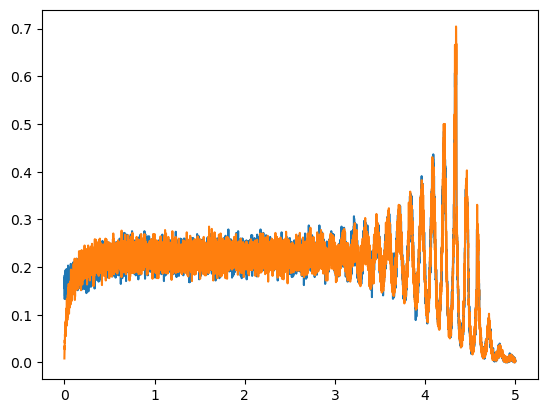

In [29]:
x,y = psm_energyout
plt.plot(x,y)

x,y = sta_energyout
plt.plot(x,y)

In [30]:
psm_energyout,psm_angle,psm_runtime,sta_energyout,sta_angle,sta_runtime = run_single_scatter_comparison(Ein,n_particles=1000000)



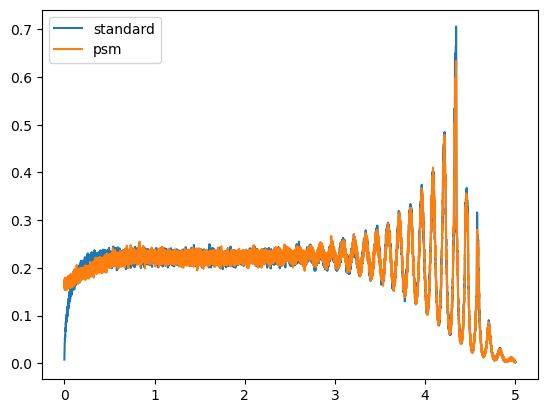

In [32]:
x,y = sta_energyout
plt.plot(x,y,label='standard')

x,y = psm_energyout
plt.plot(x,y,label='psm')
plt.legend()

In [186]:
# TODO -- I think the reason for the discrepancy for large large energy transfer is due 
# to the fact that I'm not using the SCT approximaiton -- might want to double check that 
# and make sure. If not, figure out what's wrong. If so, then make sure that I am indeed 
# correct in not using it

In [38]:
# f1 = h5py.File('./c_Graphite.h5', 'r')
f1 = h5py.File('./c_H_in_YH2.h5', 'r')


In [39]:
cvec_offsets = f1['c_H_in_YH2']['1600K']['inelastic']['distribution']['cvec'].attrs['offsets']
cvec_large = list(f1['c_H_in_YH2']['1600K']['inelastic']['distribution']['cvec'])

In [40]:
cvec_offsets

array([   0,   46,   92,  138,  184,  230,  276,  322,  368,  414,  460,
        506,  552,  598,  644,  690,  736,  782,  828,  874,  920,  966,
       1012, 1058, 1104, 1151, 1198, 1245, 1292, 1338, 1384, 1430, 1476,
       1523, 1570, 1617, 1664, 1711, 1758, 1805, 1852, 1900, 1948, 1995,
       2042, 2090, 2138, 2186, 2234, 2282, 2330, 2379, 2428, 2477, 2527,
       2577, 2628, 2679, 2731, 2784, 2838, 2892, 2947, 3003, 3060, 3118,
       3176, 3235, 3294, 3354, 3413, 3473, 3534, 3596, 3659, 3725, 3793,
       3863, 3934, 4005, 4078, 4153, 4231, 4310, 4391, 4476, 4564, 4656,
       4752, 4853, 4958, 5068, 5183, 5304, 5431, 5564, 5703, 5849, 6002,
       6163, 6331, 6506, 6691, 6887, 7092, 7309, 7541, 7782, 8032])

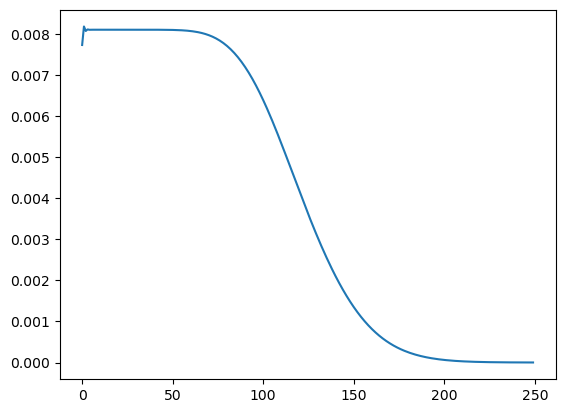

In [41]:
# plt.plot(cvec_large[0:24])
# plt.plot(cvec_large[2353:2413])
plt.plot(cvec_large[8032:])

In [62]:
kbT = f1['c_H_in_YH2']['kTs']['1600K'][()]
A = f1['c_H_in_YH2'].attrs['atomic_weight_ratio']


In [107]:
Ein

4.46

In [113]:
Ein=4.46

In [114]:
# lambda_s = f1['c_H_in_YH2']['1600K']['inelastic']['distribution'].attrs['debyeWaller']#[()]#.attrs.keys()

In [115]:
# lambda_s

In [89]:
f1.close()

In [116]:
# kbT = 1600 * kb
# A = 0.99917

In [117]:
from write_hdf5 import get_Tn_vals
TnVec2,TnVec3,lambda_s = get_Tn_vals(rho_x,rho_y,kbT,A,nphon=nphon)

In [118]:
lambda_s

3.4540287641382803

In [119]:

# betaMin,betaMax = -Ein/kbT,20.0
# cVec = getCn(Ein,betaMin,betaMax,kbT,A,nphon,lambda_s,TnVec2)
# gaussian_info = get_bounding_func_for_rejection(TnVec3,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax)

# # Run the actual sampling calculation
# betaVals3, alphaVals3, numRuns = [], [], 0
# for s in tqdm(range(int(1e5))):
#     n = np.random.choice(range(len(cVec)), size=None, replace=True, p=cVec)
#     beta,alpha,numRuns = sample_simple_rejection(n,gaussian_info,betaMin,betaMax,Ein,
#                                                  kbT,A,lambda_s,TnVec3,cVec,numRuns)
#     betaVals3.append(beta); alphaVals3.append(alpha)

# print('Acceptance Rate: {rate:.2f}%'.format(rate=len(betaVals3)/numRuns*100))



In [120]:
# cutoff_energy, aboveThisUseGaussian = params[case]

cVec = getCn(Ein,betaMin,betaMax,kbT,A,nphon,lambda_s,TnVec2)
if Ein < cutoff_energy:
    gaussian_info = get_bounding_func_for_rejection(TnVec3,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax)
else:
    gaussian_info = get_approx_fit_for_rejection(TnVec3,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax,aboveThisUseGaussian)
TnCDFs = get_TnCDFs(TnVec3,kbT)
max_vals = get_max_vals_TnCDF_sampling([Ein,],kbT,A,lambda_s)



In [121]:
alphas_leapr, betas_leapr, maxSab_leapr, sab_leapr = readLeaprOutput('../NJOY_results/HinYH2/1600K/tape24',mat=None,desiredTemp=None)
sab_leapr,alphas,fullBetas = sab_leapr.T,np.array(alphas_leapr[:]),np.array(betas_leapr[:])


Getting information for temperature:  1600.0 K


In [128]:
from random import random
from scipy.special import erf, gamma, gammaincc, gammaincinv

def sample_gaussian_approx2(n,gaussian_info,betaMin,betaMax,Ein,kbT,A,aboveThisUseGaussian,lambda_s,numRuns):
    found = False
    while not found:
        numRuns += 1
        mean, sigma, scaling = gaussian_info[n-aboveThisUseGaussian]
        guessBeta = np.random.normal(mean,sigma,1)[0]
        if guessBeta < betaMin or guessBeta > betaMax:
            continue
        alphaMin,alphaMax = getAlphaMinMax(Ein,guessBeta,kbT,A)
        xi = random()*(gammaincc(n+2,lambda_s*alphaMin)-gammaincc(n+2,lambda_s*alphaMax))
        alpha = gammaincinv(n+2, xi)/lambda_s
        return guessBeta,alpha,numRuns

    

In [129]:
betaVals4, alphaVals4, numRuns2 = [],[],0
for s in tqdm(range(int(1e6))):
    n = np.random.choice(range(len(cVec)), size=None, replace=True, p=cVec)
        
    found = False
    if Ein < cutoff_energy:           # # # Simple Rejection # # # 
        beta,alpha,numRuns2 = sample_simple_rejection(n,gaussian_info,betaMin,betaMax,Ein,
                                                     kbT,A,lambda_s,TnVec3,cVec,numRuns2)
    else:
        if n < aboveThisUseGaussian:  # # # Use fun TnCDF method # # # 
            beta,alpha,numRuns2 = sample_TnCDF_method(n,gaussian_info,betaMin,betaMax,TnCDFs,
                                                     Ein,kbT,A,lambda_s,max_vals,numRuns2)
        else:                         # # # Use Gaussian Approximation (NO Rejection) # # # 
            beta,alpha,numRuns2 = sample_gaussian_approx2(n,gaussian_info,betaMin,betaMax,Ein,kbT,A,
                                                        aboveThisUseGaussian,lambda_s,numRuns2)
    betaVals4.append(beta); alphaVals4.append(alpha)
# print('Acceptance Rate: {rate:.2f}%'.format(rate=len(betaVals4)/numRuns2*100))

    

100%|██████████████████████████████| 1000000/1000000 [01:34<00:00, 10582.21it/s]


[ Standard ] Acceptance Rate: 53.87%
[  Newer   ] Acceptance Rate: 86.29%


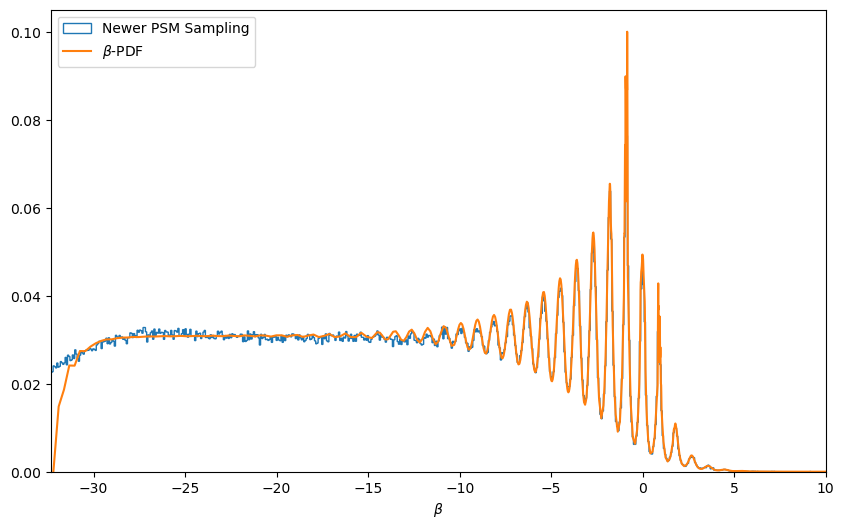

In [130]:
print('[ Standard ] Acceptance Rate: {rate:.2f}%'.format(rate=len(betaVals3)/numRuns*100))
print('[  Newer   ] Acceptance Rate: {rate:.2f}%'.format(rate=len(betaVals4)/numRuns2*100))

plt.figure(figsize=(10,6))
# plt.hist(betaVals3,bins=np.linspace(betaMin,betaMax,800),histtype='step',density=True,label='Classic PSM Sampling');
plt.hist(betaVals4,bins=np.linspace(betaMin,betaMax,800),histtype='step',density=True,label='Newer PSM Sampling');
beta_pdf_x,beta_pdf_y = getBetaPDF(sab_leapr.T,alphas,fullBetas,betaMin,betaMax,kbT,A,Ein)
plt.plot(beta_pdf_x,beta_pdf_y/np.trapz(beta_pdf_y,beta_pdf_x),label=r'$\beta$-PDF')
plt.xlim([betaMin,10])
plt.xlabel(r'$\beta$');plt.legend();



In [106]:
betaMin

-32.34696837829998

29.95370288557431 34.88818391933408


(-32.3, 29.99288180957661, 1)

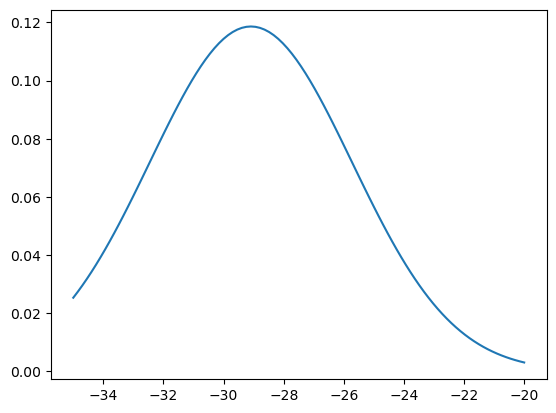

In [142]:
import scipy
def sample_gaussian_approx3(n,gaussian_info,betaMin,betaMax,Ein,kbT,A,aboveThisUseGaussian,lambda_s,numRuns):
    found = False
    while not found:
        numRuns += 1
        mean, sigma, scaling = gaussian_info[n-aboveThisUseGaussian]
        guessBeta = np.random.normal(mean,sigma,1)[0]
        guessBeta = -32.3
        x = np.linspace(-35,-20,100)
        y = scipy.stats.norm.pdf(x, mean, sigma)
        plt.plot(x,y)
        if guessBeta < betaMin or guessBeta > betaMax:
            continue
        alphaMin,alphaMax = getAlphaMinMax(Ein,guessBeta,kbT,A)
        print(alphaMin,alphaMax)
        xi = random()*(gammaincc(n+2,lambda_s*alphaMin)-gammaincc(n+2,lambda_s*alphaMax))
        alpha = gammaincinv(n+2, xi)/lambda_s
        return guessBeta,alpha,numRuns

sample_gaussian_approx3(150,gaussian_info,betaMin,betaMax,Ein,kbT,A,aboveThisUseGaussian,lambda_s,0)

-32.34696837829998

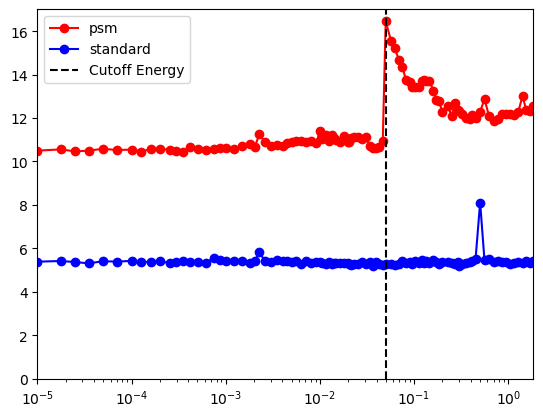

In [24]:
# total_runtime = [runtimes['psm'][i]['total'] for i in range(len(runtimes['psm']))]
# plt.plot(EinVals,total_runtime,'ro-',label='psm')
# total_runtime = [runtimes['sta'][i]['total'] for i in range(len(runtimes['sta']))]
# plt.plot(EinVals,total_runtime,'bo-',label='standard')
# plt.xlim([1e-5,1.855])
# ylim = plt.gca().get_ylim()
# plt.plot([cutoff_energy,cutoff_energy],[0,100],'k--',label='Cutoff Energy')
# plt.ylim([0,ylim[1]]); plt.legend()
# plt.savefig('./timing/'+case+'_'+Tname+'_total_time.png')
# plt.xscale('log')

In [202]:
from write_hdf5 import get_Tn_vals,get_bounding_func_for_rejection2
kbT = 0.0253
A = 0.999167
TnVec2,TnVec3,lambda_s = get_Tn_vals(rho_x,rho_y,kbT,A,nphon=100)

In [203]:
TnVec2,TnVec3,lambda_s = get_Tn_vals(rho_x,rho_y,kbT,A)
# max_energy = 1.855

Ein_vec = egrid[np.where(egrid <= max_energy*(1+1e-5))]
T1_x, T1_y = getRealisticTn(TnVec2[0][0],TnVec2[0][1])

info = []
cvecs = []
max_vals = []
for Ein in tqdm(Ein_vec):
    Ein = 0.005
    betaMin = -Ein/kbT
    betaMax = 20.0
    # print('\t\t Getting cVec')
    cVec = getCn(Ein,betaMin,betaMax,kbT,A,nphon,lambda_s,TnVec2)
    if Ein < cutoff_energy:
        # print('\t\t Calculating Gaussian Envelope')
#                 gaussian_info = get_bounding_func_for_rejection(TnVec3,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax)
        gaussian_info = get_bounding_func_for_rejection2(TnVec3,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax)
    else:
        # print('\t\t Calculating Gaussian Fit')
        gaussian_info = get_approx_fit_for_rejection(TnVec3,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax,
                                                     aboveThisUseGaussian)
    # TnCDFs = get_TnCDFs(TnVec3,kbT)
    # print('\t\t Computing Max Vals (new sampling)')
    max_vals.append(get_max_vals_TnCDF_sampling([Ein,],kbT,A,lambda_s)[0])

    # print('\t\t Packing it all up...')
    info_this_energy = [gaussian_info,cVec]
    info.append(info_this_energy)
    break

  0%|                                                    | 0/98 [00:04<?, ?it/s]


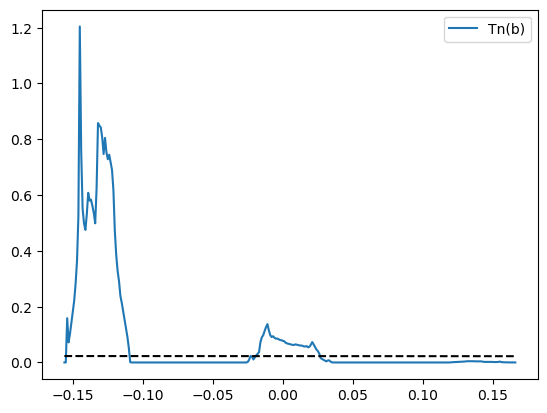

In [204]:
from cn import getNContribution, getCn 
from scipy.stats import norm

Ein = 0.005
n = 0

betaMin,betaMax = -Ein/kbT, 20
fullBetas = np.linspace(betaMin+1e-10,betaMax,500)
valid_betas = fullBetas[np.where((fullBetas >= betaMin) & (fullBetas <= betaMax))]
nContribsBetaDep = np.array(getNContribution(Ein,kbT,A,nphon,fullBetas,lambda_s,betaMin,betaMax))
cVec = getCn(Ein,betaMin,betaMax,kbT,A,nphon,lambda_s,TnVec2)
cVec = cVec[:np.where(cVec>1e-5)[-1][-1]+1]
xy_vals = get_x_y_for_rejection_envelopes(TnVec2,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax)


tx,ty= np.array(TnVec2[n][0])/kbT,np.array(TnVec2[n][1])
wx,wy= xy_vals[n][0],xy_vals[n][2]
twy  = np.array(xy_vals[n][1])

plt.plot(tx*kbT+Ein,ty,label='Tn(b)');          
# plt.plot(wx*kbT+Ein,wy,'g-',label='wn(b,E)')
# plt.plot(wx*kbT+Ein,twy*cVec[n],label='Tn*wn'); 

mean,width,scaling = gaussian_info[n]
gaussian  = norm.pdf(tx*kbT+Ein,mean,width)*scaling
plt.plot(tx*kbT+Ein,gaussian,'k--')
plt.legend(); 
# plt.ylim([-0.001,0.01])
# plt.xlim([0,0.2])
plt.show();


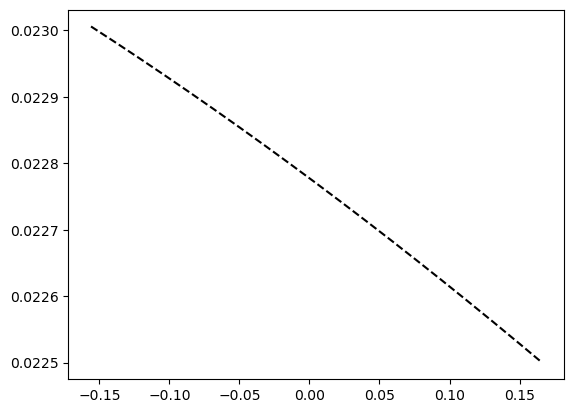

In [205]:
plt.plot(tx*kbT+Ein,gaussian,'k--')


In [206]:
# There's a problem with the gaussian fit function (again). Please address 

In [207]:
Ein

0.005

In [208]:
!ls

c_H_in_ZrH.h5            out                      sta_cross_sections.xml
cross_sections.xml       psm.h5                   summary.h5
geometry.xml             psm_cross_sections.xml   tallies.out
making_hdf5_inputs.ipynb settings.xml             tallies.xml
materials.xml            sta.h5


(-0.0001, 0.001)

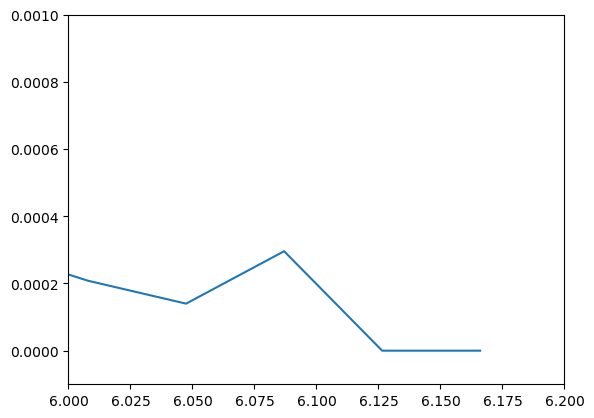

In [216]:
plt.plot((TnVec2[0][0]-Ein)/kbT,TnVec2[0][1])
plt.xlim(6.0,6.2)
plt.ylim([-0.0001,0.001])

In [224]:
n = 0
print(np.interp(0.15433,TnVec2[n][0],TnVec2[n][1],left=0,right=0))
print(TnVec2[n][0][0],TnVec2[n][0][1]-TnVec2[n][0][0])


0.0004689336295350981
-0.161 0.0010000000000000009


In [210]:
import numpy as np
from numpy.random import random
from scipy import special
from scipy.special import erf, gamma, gammaincc, gammaincinv
from misc import getAlphaMinMax
from scipy.stats import norm
def sample_simple_rejection2(n,gaussian_info,betaMin,betaMax,Ein,kbT,A,lambda_s,TnVec3,cVec,numRuns):
    found = False
    while not found:
        numRuns += 1
        mean, sigma, scaling = gaussian_info[n]
        guessBeta = np.random.normal(mean,sigma,1)[0]
        guessBeta = 6.1
        if guessBeta < betaMin or guessBeta > betaMax:
            continue

        alphaMin,alphaMax = getAlphaMinMax(Ein,guessBeta,kbT,A)
        nContribs_val = -((gammaincc(n+2,lambda_s*alphaMax)-gammaincc(n+2,lambda_s*alphaMin)))/lambda_s 
        Tn_piece = np.interp(guessBeta*kbT,TnVec3[n][0],TnVec3[n][1],left=0,right=0)
        guessVal = nContribs_val * Tn_piece /cVec[n]
        sample_point = random()*scaling*norm.pdf([guessBeta],mean,sigma)
        print(Ein,guessBeta,kbT,A)
        print(guessBeta,alphaMin,alphaMax,Tn_piece,guessVal)
        print()
        if sample_point < guessVal:
            xi = random()*(gammaincc(n+2,lambda_s*alphaMin)-gammaincc(n+2,lambda_s*alphaMax))
            alpha = gammaincinv(n+2, xi)/lambda_s
            return guessBeta,alpha,numRuns


In [211]:
# Ein = 6.0e-1
# Ein = 1.0
Ein = 2.5e-5
Ein = 0.005

betaMin,betaMax = -Ein/kbT,20.0

cVec = getCn(Ein,betaMin,betaMax,kbT,A,nphon,lambda_s,TnVec2)

gaussian_info = get_bounding_func_for_rejection(TnVec3,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax)

# Run the actual sampling calculation
betaVals3 = []
alphaVals3 = []
numRuns = 0
# for s in tqdm(range(int(1e5))):
for s in tqdm(range(int(1e2))):
    n = np.random.choice(range(len(cVec)), size=None, replace=True, p=cVec)
    n = 0
    beta,alpha,numRuns = sample_simple_rejection2(n,gaussian_info,betaMin,betaMax,Ein,
                                                 kbT,A,lambda_s,TnVec3,cVec,numRuns)
    betaVals3.append(beta)
    alphaVals3.append(alpha)

print('Acceptance Rate: {rate:.2f}%'.format(rate=len(betaVals3)/numRuns*100))



100%|████████████████████████████████████████| 100/100 [00:00<00:00, 783.08it/s]

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 0.0253 0.999167
6.1 4.267587396091226 8.73375655741414 0.0004689336295350981 0.0007692598175412816

0.005 6.1 

In [ ]:
6.1   4.26759   8.73376    0.000471477   0.000773432

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(6.0, 6.5)

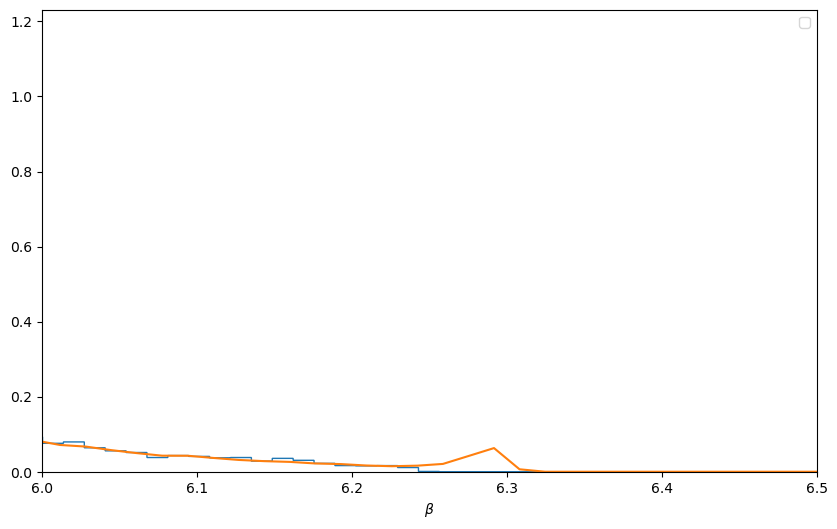

In [183]:
plt.figure(figsize=(10,6))
plt.hist(betaVals3,bins=np.linspace(betaMin,betaMax,1500),histtype='step',density=True);
plt.xlim([betaMin,10])
plt.xlabel(r'$\beta$');plt.legend();
x,y = (eouts['psm'][i][0]-Ein)/kbT,eouts['psm'][i][1]
plt.plot(x,y/np.trapz(y,x),label='psm')

mean,width,scaling = gaussian_info[n]
gaussian  = norm.pdf(x,mean,width)*scaling*500
# plt.plot(x,gaussian,'k--')
plt.xlim([6,6.5])

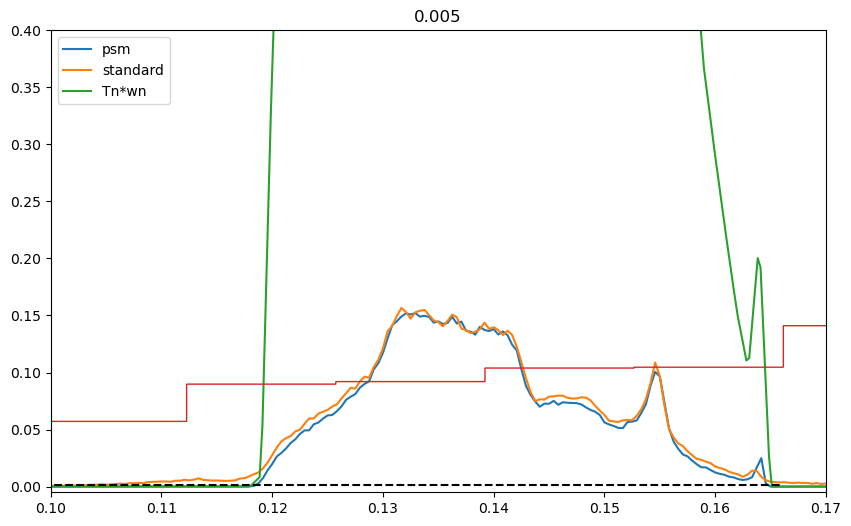

In [178]:
i = 0
plt.figure(figsize=(10,6))
plt.plot(eouts['psm'][i][0],eouts['psm'][i][1]/100,label='psm')
plt.plot(eouts['sta'][i][0],eouts['sta'][i][1]/100,label='standard')



Ein = EinVals[i]
Ein = 0.005
n = 0

betaMin,betaMax = -Ein/kbT, 20
fullBetas = np.linspace(betaMin+1e-10,betaMax,500)
valid_betas = fullBetas[np.where((fullBetas >= betaMin) & (fullBetas <= betaMax))]
nContribsBetaDep = np.array(getNContribution(Ein,kbT,A,nphon,fullBetas,lambda_s,betaMin,betaMax))
cVec = getCn(Ein,betaMin,betaMax,kbT,A,nphon,lambda_s,TnVec2)
cVec = cVec[:np.where(cVec>1e-5)[-1][-1]+1]
xy_vals = get_x_y_for_rejection_envelopes(TnVec2,Ein,kbT,A,lambda_s,cVec,betaMin,betaMax)


tx,ty= np.array(TnVec2[n][0])/kbT,np.array(TnVec2[n][1])
wx,wy= xy_vals[n][0],xy_vals[n][2]
twy  = np.array(xy_vals[n][1])

# plt.plot(tx*kbT+Ein,ty*80,label='Tn(b)');          
# plt.plot(wx*kbT+Ein,wy,label='wn(b,E)')
plt.plot(wx*kbT+Ein,twy*cVec[n]*480,label='Tn*wn'); 

mean,width,scaling = gaussian_info[n]
gaussian  = norm.pdf(tx*kbT+Ein,mean,width)*scaling
plt.plot(tx*kbT+Ein,gaussian,'k--')
plt.hist(betaVals3,bins=np.linspace(betaMin,betaMax,1500),histtype='step',density=True);


x,y = eouts['psm'][i]
# plt.plot([Ein,Ein],[0,max(y)],'k--')
for j in range(np.where(y==max(y))[0][0]): 
    if y[j] > 1e-5*max(y):  left = x[j]; break
for j in range(len(y)-1,np.where(y==max(y))[0][0],-5): 
    if y[j] > 1e-3*max(y): right = x[j]; break
plt.ylim([-0.005,0.4])
plt.title(str(EinVals[i])); 
plt.xlim([left,right]); 
plt.xlim([0.10,0.17]); 
plt.legend(); plt.show();


(-0.0005, 0.02)

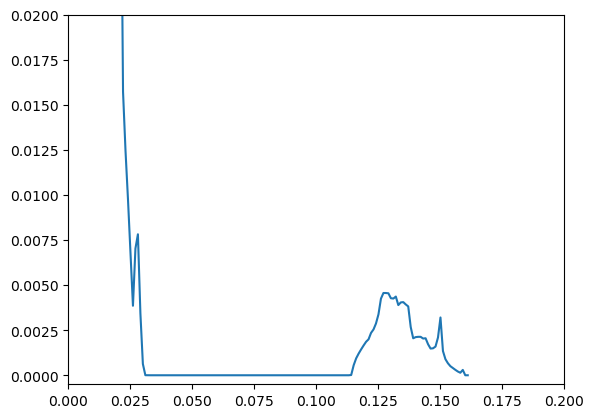

In [175]:

plt.plot(TnVec2[0][0],TnVec2[0][1])
plt.xlim([0.0,0.20])
plt.ylim([-0.0005,0.02])

In [193]:
TnVec2[0][0][-1]

0.161

In [195]:
(0.161-Ein)/kbT

6.16600790513834